# CLASIFICACIÓN DE IMÁGENES HISTOPATOLÓGICAS DE CÁNCER DE MAMA USANDO REDES NEURONALES CONVOLUCIONALES

## Artificial Neural Networks - 2020-2

* Gantiva, S esgantivar@unal.edu.co
* Carrillo, E eccarrilloe@unal.edu.co
* Garzón, E egarzonv@unal.edu.co
* Velásquez, D arvelasqueza@unal.edu.co

Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Copy h5py datasets

In [2]:
!cp '/content/drive/Shared drives/Redes Neuronales/Proyecto - RN/datasets/breakhis_40PX_96.hdf5' .
!cp '/content/drive/Shared drives/Redes Neuronales/Proyecto - RN/datasets/breakhis_100PX_96.hdf5' .
!cp '/content/drive/Shared drives/Redes Neuronales/Proyecto - RN/datasets/breakhis_200PX_96.hdf5' .
!cp '/content/drive/Shared drives/Redes Neuronales/Proyecto - RN/datasets/breakhis_400PX_96.hdf5' .

Install additional libraries

In [3]:
!pip install fuel -q

     |████████████████████████████████| 194kB 6.5MB/s 


Load libraries

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

In [5]:
from fuel.datasets import H5PYDataset

In [6]:
import matplotlib.pyplot as plt
import itertools

In [7]:
class ReturnBestEarlyStopping(EarlyStopping):
    def __init__(self, **kwargs):
        super(ReturnBestEarlyStopping, self).__init__(**kwargs)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            if self.verbose > 0:
                print(f'\nEpoch {self.stopped_epoch + 1}: early stopping')
        elif self.restore_best_weights:
            if self.verbose > 0:
                print('Restoring model weights from the end of the best epoch.')
            self.model.set_weights(self.best_weights)

In [8]:
def plot_metric(history, metric, init=0, title='Training and validation', path='/notebooks/storage', save=False, ext='pdf'):
  train_metrics = history[metric][init:]
  val_metrics = history['val_'+metric][init:]
  epochs = [i for i in range(init + 1, len(train_metrics) + 1 + init)]
  plt.plot(epochs, train_metrics, 'bo--')
  plt.plot(epochs, val_metrics, 'ro-')
  plt.title(title)
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend(["train_"+metric, 'val_'+metric])
  if save:
    plt.savefig(f"{path}/{title}.{ext}")
  plt.show()

In [9]:
def save_history(history, name, path='/notebooks/storage/histories'):
    '''
        history: Generated from training process
        name: Name to persist the history on storage
    '''
    hist_df = pd.DataFrame(history.history) 
    hist_json_file = f'{path}/{name}.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

In [10]:
def load_history(name, path='/notebooks/storage/histories'):    
    '''
        name: Name to find and load history
    '''
    return pd.read_json(f'{path}/{name}.json')

In [12]:
def save_model_utils(model, path='/notebooks/storage/models'):
    model.save(f'{path}/{model.name}.h5')
    print(f'saved as: {model.name}')

In [13]:
def load_model_utils(name, path='/notebooks/storage/models'):
    print(f'{path}/{name}.h5')
    return load_model(f'{path}/{name}.h5')

In [14]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues,
                        save=False,
                        path='/content',
                        ext='pdf'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")

    # print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if save:
      plt.savefig(f"{path}/{title}.{ext}")

In [ ]:
lr = 0.0001

In [ ]:
for px in [40]:
  model = Sequential(name=f'{px}PX_96_shallow')
  model.add(Conv2D(input_shape=(96,96,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(Conv2D(filters=64,kernel_size=(4,4),padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.5))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=2, activation="softmax"))

  model.summary()

  earlyStopping = ReturnBestEarlyStopping(monitor='val_accuracy', 
                                          patience=50, 
                                          verbose=1, 
                                          mode='max', 
                                          restore_best_weights=True)
  callback_list = [earlyStopping]

  model.compile(optimizer=Adam(learning_rate=lr), 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
  
  x_train = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('train',), sources = ['images'], load_in_memory=True).data_sources[0]
  y_train = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('train',), sources = ['labels'], load_in_memory=True).data_sources[0]
  y_train = tf.keras.utils.to_categorical(y_train, 2)
  print('train', x_train.shape, y_train.shape)

  x_dev = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('dev',), sources = ['images'], load_in_memory=True).data_sources[0]
  y_dev = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('dev',), sources = ['labels'], load_in_memory=True).data_sources[0]
  y_dev = tf.keras.utils.to_categorical(y_dev, 2)
  print('dev', x_dev.shape, y_dev.shape)

  history = model.fit(x_train, 
                      y_train, 
                      epochs=50,
                      verbose=1,
                      batch_size=64, 
                      callbacks=callback_list,
                      validation_data=(x_dev, y_dev))
  
  save_model_utils(model, path='/content')
  save_history(history, f'{px}PX_shallow', path='/content')

  x_test = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('test',), sources = ['images'], load_in_memory=True).data_sources[0]
  y_test = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('test',), sources = ['labels'], load_in_memory=True).data_sources[0]
  y_true = H5PYDataset(f'breakhis_{px}PX_96.hdf5', which_sets=('test',), sources = ['labels'], load_in_memory=True).data_sources[0]
  y_test = tf.keras.utils.to_categorical(y_test, 2)
  print('test', x_test.shape, y_test.shape)

  score_train = model.evaluate(x_train, y_train, verbose=0)
  print('train', score_train)
  score_dev = model.evaluate(x_dev, y_dev, verbose=0)
  print('dev', score_dev)
  score_test = model.evaluate(x_test, y_test, verbose=0)
  print('test', score_test)

Model: "40PX_96_shallow"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 96, 96, 64)        1792      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 96, 96, 64)        65600     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 48, 48, 128)       73856     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 48, 48, 128)       147584    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 24, 24, 128)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 24, 24, 128)   

In [ ]:
!mv '/content/40PX_96_shallow.h5' '/content/drive/Shared drives/Redes Neuronales/Proyecto - RN/models'
!mv '/content/100PX_96_shallow.h5' '/content/drive/Shared drives/Redes Neuronales/Proyecto - RN/models'
!mv '/content/200PX_96_shallow.h5' '/content/drive/Shared drives/Redes Neuronales/Proyecto - RN/models'
!mv '/content/400PX_96_shallow.h5' '/content/drive/Shared drives/Redes Neuronales/Proyecto - RN/models'

!mv '/content/40PX_shallow.json' '/content/drive/Shared drives/Redes Neuronales/Proyecto - RN/histories'
!mv '/content/100PX_shallow.json' '/content/drive/Shared drives/Redes Neuronales/Proyecto - RN/histories'
!mv '/content/200PX_shallow.json' '/content/drive/Shared drives/Redes Neuronales/Proyecto - RN/histories'
!mv '/content/400PX_shallow.json' '/content/drive/Shared drives/Redes Neuronales/Proyecto - RN/histories'

### Evaluate

In [15]:
PX = 40

In [16]:
model_load = load_model_utils(f'{PX}PX_96_shallow', path='/content/drive/Shared drives/Redes Neuronales/Proyecto - RN/models')

/content/drive/Shared drives/Redes Neuronales/Proyecto - RN/models/40PX_96_shallow.h5


In [17]:
x_test = H5PYDataset(f'breakhis_{PX}PX_96.hdf5', which_sets=('test',), sources = ['images'], load_in_memory=True).data_sources[0]
y_test = H5PYDataset(f'breakhis_{PX}PX_96.hdf5', which_sets=('test',), sources = ['labels'], load_in_memory=True).data_sources[0]
y_true = H5PYDataset(f'breakhis_{PX}PX_96.hdf5', which_sets=('test',), sources = ['labels'], load_in_memory=True).data_sources[0]
y_test = tf.keras.utils.to_categorical(y_test, 2)
x_test.shape, y_test.shape, y_true.shape

((598, 96, 96, 3), (598, 2), (598,))

In [18]:
y_pred = model_load.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true=y_true,
                      y_pred=y_pred)
cm

array([[107,  80],
       [ 25, 386]])

In [19]:
ext = 'png'

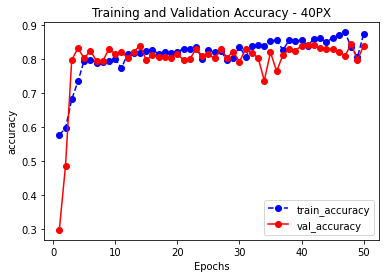

In [20]:
plot_metric(load_history(f'{PX}PX_shallow', path='/content/drive/Shared drives/Redes Neuronales/Proyecto - RN/histories'), 
            'accuracy', 
            title=f'Training and Validation Accuracy - {PX}PX', 
            path='/content', 
            save=True,
            ext=ext)

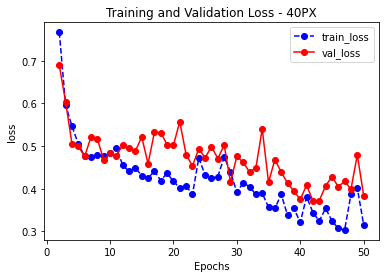

In [21]:
plot_metric(load_history(f'{PX}PX_shallow', path='/content/drive/Shared drives/Redes Neuronales/Proyecto - RN/histories'), 
            'loss', 
            init=1,
            title=f'Training and Validation Loss - {PX}PX', 
            path='/content', 
            save=True,
            ext=ext)

In [22]:
cm_plot_labels = ['bening','malignant']

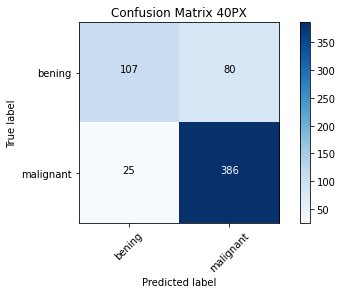

In [23]:
plot_confusion_matrix(cm=cm, 
                      classes=cm_plot_labels, 
                      title=f'Confusion Matrix {PX}PX', 
                      save=True,
                      ext=ext)